In [ ]:
import fasttext
import pandas as pd
import numpy as np
import io
import re
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import spatial
from tqdm import tqdm
import seaborn as sns
import nltk
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
import matplotlib.pyplot as plt
import gensim
from gensim.models import word2vec
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = pd.read_csv('data/file_information.csv')

In [ ]:
numerical_categories = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}

for key, val in numerical_categories.items():
    data = data.replace(key, val)
        
# add class labels 
data['Class'] = np.where(data['Category'] != 0, 1, 0) # label whether plagiarized (1) or not (0)
data['Class'] = np.where(data['Category'] == -1, -1, data['Class']) # -1 category is origin => class is -1 (meaningless)

In [ ]:
def process_file(file):
    # put text in all lower case letters 
    all_text = file.read().lower()

    # remove all non-alphanumeric chars
    all_text = re.sub(r"[^a-zA-Z0-9]", " ", all_text)
    # remove newlines/tabs, etc. so it's easier to match phrases, later
    all_text = re.sub(r"\t", " ", all_text)
    all_text = re.sub(r"\n", " ", all_text)
    all_text = re.sub("  ", " ", all_text)
    all_text = re.sub("   ", " ", all_text)
    
    return all_text

In [ ]:
#Add processed text as a new column
texts = []
for index, row in data.iterrows():
    filename = 'data/'+row['File']
    with open(filename, 'r', encoding='utf-8', errors='ignore') as fh:
        processed_text = process_file(fh)
        texts.append(processed_text)
data['Text'] = texts

In [ ]:
data.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [ ]:
orig = data[data['Class'] == -1]
answers = data[data['Class']!=-1]

In [ ]:
X = answers.drop(columns='Class')
y = answers['Class']
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.3,stratify=y,random_state=10)

### Applying fasttext

In [ ]:
def LoadFastText(path):
    input_file = io.open(path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    no_of_words, vector_size = map(int, input_file.readline().split())
    word_to_vector: Dict[str, List[float]] = dict()
    for i, line in enumerate(input_file):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        vector = list(map(float, tokens[1:]))
        assert len(vector) == vector_size
        word_to_vector[word] = vector
    return word_to_vector

In [ ]:
model=LoadFastText("C:/Users/fahan/Desktop/CENTELLA/NLP/NLP/wiki-news-300d-1M.vec")

In [ ]:
len(model['hostel'])

300

In [ ]:

stop_words=stopwords.words('english')
def cosine_similarity(query, source, query_index, source_index):
    q_embd=np.mean([model[word] for word in query['Text'].iloc[query_index] if (word not in stop_words) and (word in model.keys())],axis=0)
    s_embd=np.mean([model[word] for word in source['Text'].iloc[source_index] if (word not in stop_words) and (word in model.keys())], axis=0)
    sm=1-spatial.distance.cosine(q_embd,s_embd)
    return sm

In [ ]:
fasttext_sim_array=np.empty((len(train_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(train_X))):
        fasttext_sim_array[j][i]=cosine_similarity(train_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:05<00:00, 12.90it/s]


In [ ]:
fasttext_sim_array.shape

(66, 5)

In [ ]:
train_max_similarity= fasttext_sim_array.max(axis=1)
train_max_similarity

array([0.99893363, 0.99975454, 0.99912965, 0.99880892, 0.99919257,
       0.99942631, 0.9981226 , 0.99894584, 0.99918629, 0.9992394 ,
       0.99961002, 0.99956913, 0.99827622, 0.99829969, 0.99870538,
       0.9997535 , 0.99850919, 0.99981878, 0.99761846, 0.99955926,
       0.99882067, 0.99875517, 0.99795111, 0.99609692, 0.99999439,
       0.99943581, 0.99774802, 0.99952642, 0.99907248, 0.99881314,
       0.99683489, 0.99828762, 0.9990432 , 0.99898669, 0.99886549,
       0.99947652, 0.99942406, 0.99825119, 0.99989061, 0.99928782,
       0.99952061, 0.99871316, 0.99965257, 0.99838365, 0.99947585,
       0.99898226, 0.99837099, 0.99916037, 0.99725759, 0.99922375,
       0.99917427, 0.99998591, 0.99962609, 0.9984984 , 0.9972805 ,
       0.99868331, 0.99967295, 0.99757967, 0.99874216, 0.99768293,
       0.99938509, 0.99935023, 0.99995152, 0.99886435, 0.9997425 ,
       0.9986856 ])

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'FasText_Similarity')]

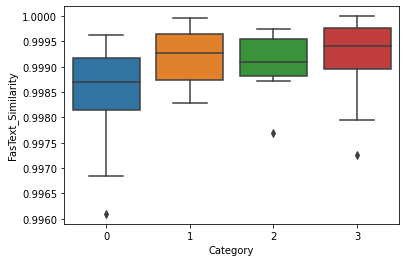

In [ ]:
box_plot=sns.boxplot(x=train_X['Category'],y=train_max_similarity.ravel())
box_plot.set(xlabel='Category',ylabel='FasText_Similarity')

In [ ]:
roc_auc_score(train_y,train_max_similarity.ravel())

0.7423076923076923

In [ ]:
fpr,tpr,threshold = roc_curve(train_y,train_max_similarity.ravel())
print("fpr:",fpr,"\n")
print("tpr:",tpr,"\n")
print("threshold",threshold,"\n")


fpr: [0.         0.         0.         0.03846154 0.03846154 0.07692308
 0.07692308 0.11538462 0.11538462 0.30769231 0.30769231 0.42307692
 0.42307692 0.46153846 0.46153846 0.5        0.5        0.61538462
 0.61538462 0.69230769 0.69230769 0.76923077 0.76923077 0.80769231
 0.80769231 0.92307692 0.92307692 1.        ] 

tpr: [0.    0.025 0.25  0.25  0.3   0.3   0.4   0.4   0.55  0.55  0.65  0.65
 0.8   0.8   0.825 0.825 0.85  0.85  0.875 0.875 0.925 0.925 0.95  0.95
 0.975 0.975 1.    1.   ] 

threshold [1.99999439 0.99999439 0.99965257 0.99962609 0.99956913 0.99955926
 0.99947585 0.99943581 0.9992394  0.99916037 0.99898669 0.99893363
 0.99875517 0.99874216 0.99871316 0.99870538 0.9986856  0.9984984
 0.99838365 0.99829969 0.99827622 0.9981226  0.99795111 0.99774802
 0.99768293 0.9972805  0.99725759 0.99609692] 



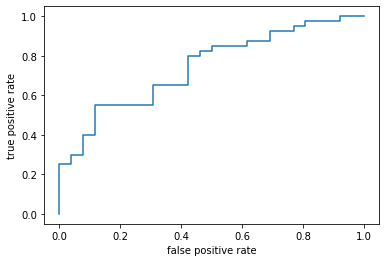

In [ ]:
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(fpr,tpr)

In [ ]:
# get the best threshold using Youden’s J statistic.
J = tpr - fpr
ix = np.argmax(J)
best_thresh = threshold[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.999239


In [ ]:
train_Y_Pred=np.where(train_max_similarity.ravel()>best_thresh,1,0)
train_Y_Pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [ ]:
# training accuracy
accuracy_train= accuracy_score(train_y,train_Y_Pred)
print("Training Accuracy:",accuracy_train)

Training Accuracy: 0.6666666666666666


In [ ]:
fasttext_test_sim_array=np.empty((len(test_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(test_X))):
        fasttext_test_sim_array[j][i]=cosine_similarity(test_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 12.69it/s]


In [ ]:
max_fasttext_test=fasttext_test_sim_array.max(axis=1)
max_fasttext_test

array([0.99911861, 0.99932141, 0.99793526, 0.9988939 , 0.99871376,
       0.99939458, 0.99993015, 0.99980437, 0.99912603, 0.99968946,
       0.9995411 , 0.99850012, 0.99742651, 0.99940495, 0.99917534,
       0.99946389, 0.99999614, 0.99904019, 0.99846856, 0.99907658,
       0.9977243 , 0.99901488, 0.99918197, 0.99965496, 0.99896312,
       0.99942402, 0.99974273, 0.99940852, 0.99835377])

<AxesSubplot:xlabel='Category'>

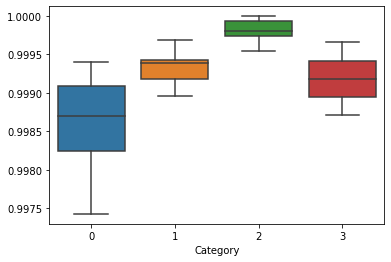

In [ ]:
sns.boxplot(x=test_X['Category'],y=max_fasttext_test.ravel())

In [ ]:
roc_auc_score(test_y,max_fasttext_test)

0.9019607843137255

In [ ]:
test_Y_Pred=np.where(max_fasttext_test.ravel()>best_thresh,1,0)
test_Y_Pred

array([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0])

In [ ]:
# test accuracy
test_accuracy= accuracy_score(test_y,test_Y_Pred)
print("Test Accuracy:",test_accuracy)

Test Accuracy: 0.7931034482758621


In [ ]:
ft_test_y_cat_1=test_y[test_X['Category']==0]
ft_test_y_Pred_cat_1=test_Y_Pred[test_X['Category']==0]
ft_test_y_cat_2=test_y[test_X['Category']==1]
ft_test_y_Pred_cat_2=test_Y_Pred[test_X['Category']==1]
ft_test_y_cat_3=test_y[test_X['Category']==2]
ft_test_y_Pred_cat_3=test_Y_Pred[test_X['Category']==2]
ft_test_y_cat_4=test_y[test_X['Category']==3]
ft_test_y_Pred_cat_4=test_Y_Pred[test_X['Category']==3]


In [ ]:
ft_train_y_cat_1=train_y[train_X['Category']==0]
ft_train_y_Pred_cat_1=train_Y_Pred[train_X['Category']==0]
ft_train_y_cat_2=train_y[train_X['Category']==1]
ft_train_y_Pred_cat_2=train_Y_Pred[train_X['Category']==1]
ft_train_y_cat_3=train_y[train_X['Category']==2]
ft_train_y_Pred_cat_3=train_Y_Pred[train_X['Category']==2]
ft_train_y_cat_4=train_y[train_X['Category']==3]
ft_train_y_Pred_cat_4=train_Y_Pred[train_X['Category']==3]

In [ ]:
# test accuracy
ft_test_accuracy_cat_1= accuracy_score(ft_test_y_cat_1,ft_test_y_Pred_cat_1)
print("Test Accuracy Category 1:",ft_test_accuracy_cat_1)
ft_test_accuracy_cat_2= accuracy_score(ft_test_y_cat_2,ft_test_y_Pred_cat_2)
print("Test Accuracy Category 2:",ft_test_accuracy_cat_2)
ft_test_accuracy_cat_3= accuracy_score(ft_test_y_cat_3,ft_test_y_Pred_cat_3)
print("Test Accuracy Category 3:",ft_test_accuracy_cat_3)
ft_test_accuracy_cat_4= accuracy_score(ft_test_y_cat_4,ft_test_y_Pred_cat_4)
print("Test Accuracy Category 4:",ft_test_accuracy_cat_4)

Test Accuracy Category 1: 0.9166666666666666
Test Accuracy Category 2: 0.6666666666666666
Test Accuracy Category 3: 1.0
Test Accuracy Category 4: 0.3333333333333333


In [ ]:
# train accuracy
ft_train_acc_cat_1=accuracy_score(ft_train_y_cat_1,ft_train_y_Pred_cat_1)
print("Train Accuracy Category 1:",ft_train_acc_cat_1)
ft_train_acc_cat_2=accuracy_score(ft_train_y_cat_2,ft_train_y_Pred_cat_2)
print("Train Accuracy Category 2:",ft_train_acc_cat_2)
ft_train_acc_cat_3=accuracy_score(ft_train_y_cat_3,ft_train_y_Pred_cat_3)
print("Train Accuracy Category 3:",ft_train_acc_cat_3)
ft_train_acc_cat_4=accuracy_score(ft_train_y_cat_4,ft_train_y_Pred_cat_4)
print("Train Accuracy Category 4:",ft_train_acc_cat_4)

Train Accuracy Category 1: 0.8846153846153846
Train Accuracy Category 2: 0.5
Train Accuracy Category 3: 0.42857142857142855
Train Accuracy Category 4: 0.625


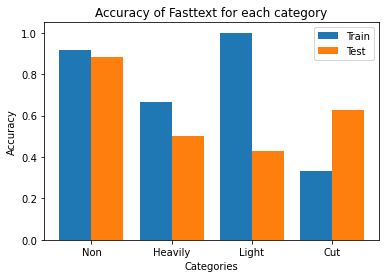

In [ ]:
X =  ['Non','Heavily','Light','Cut']
Train_Accuracy = [ft_test_accuracy_cat_1,ft_test_accuracy_cat_2,ft_test_accuracy_cat_3,ft_test_accuracy_cat_4]
Test_Accuracy = [ft_train_acc_cat_1,ft_train_acc_cat_2,ft_train_acc_cat_3,ft_train_acc_cat_4]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Train_Accuracy, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Test_Accuracy, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Accuracy")
plt.title("Accuracy of Fasttext for each category")
plt.legend()
plt.show()